In [25]:
! pip install -q kaggle

In [26]:
from google.colab import files

In [27]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"aydafrough","key":"6f11d390d25b1f8e7987d65c72badb9a"}'}

In [28]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                                 title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/global-youtube-statistics-2023                     Global YouTube Statistics 2023                       60KB  2023-07-28 15:36:38           5708        195  1.0              
nelgiriyewithana/countries-of-the-world-2023                        Global Country Information Dataset 2023              23KB  2023-07-08 20:37:33          13338        534  1.0              
brunoalarcon123/top-200-spotify-songs-dataset                       Top 200 Spotify Songs Dataset                        35MB  2023-08-18 05:36:12           1634         55

In [29]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [30]:
import zipfile
zip_ref = zipfile.ZipFile('chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [31]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

from pathlib import Path
from typing import List,Dict

In [32]:
train_path=Path('chest_xray/train')
test_path=Path('chest_xray/test')
val_path=Path('chest_xray/val')


In [33]:
device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [34]:
import random
from PIL import Image

image_list=[]
image_list_path=list(test_path.glob("*/*.jpeg"))
for i in range(10):
  image_path=random.choice(image_list_path)
  image_class=image_path.parent.stem
  img=Image.open(image_path)

  image_list.append({'img':img, 'image_class':image_class})


image_list

[{'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1280x848>,
  'image_class': 'PNEUMONIA'},
 {'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1376x1040>,
  'image_class': 'NORMAL'},
 {'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1000x776>,
  'image_class': 'PNEUMONIA'},
 {'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=936x528>,
  'image_class': 'PNEUMONIA'},
 {'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1080x720>,
  'image_class': 'PNEUMONIA'},
 {'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1873x1478>,
  'image_class': 'NORMAL'},
 {'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1438x1260>,
  'image_class': 'PNEUMONIA'},
 {'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1160x688>,
  'image_class': 'PNEUMONIA'},
 {'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1600x992>,
  'image_class': 'PNEUMONIA'},
 {'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1072x8

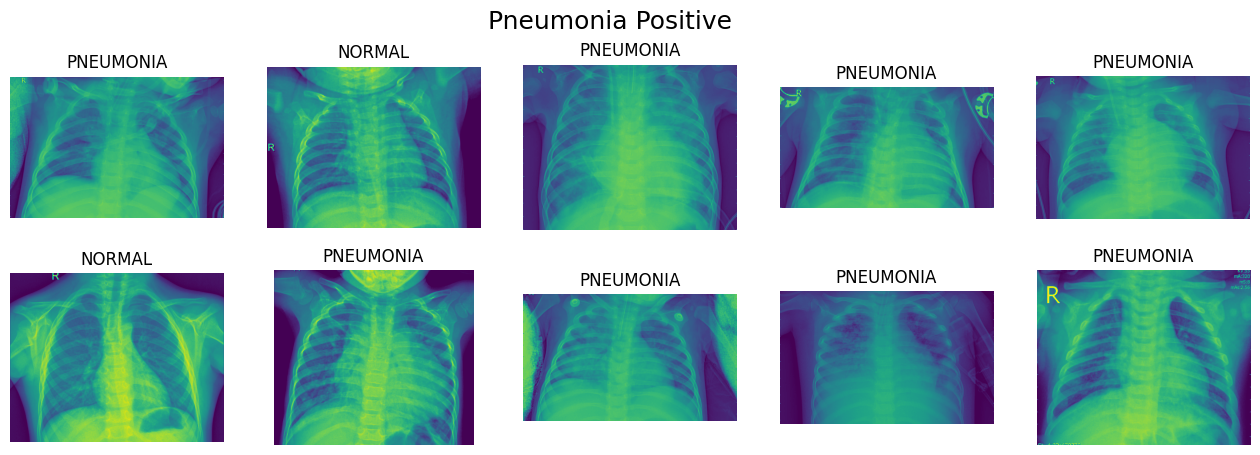

In [35]:
#visualize our data
fig = plt.figure(figsize=(16,5))
fig.suptitle("Pneumonia Positive", size=18)
for i, image in enumerate(image_list):
  #fig.add_subplot(2,5,len(image_list),frameon=False)
  plt.subplot(2,5,i+1,frameon=False)
  plt.imshow(image["img"])
  plt.title(image["image_class"])
  plt.axis(False)



fig.show()

In [36]:
#set transforms
normalize=transforms.Normalize(mean=[0.485,0.456,0.406],
                               std=[0.229,0.224,0.225])
data_transform= transforms.Compose([
    transforms.Resize(size=(150,150)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    normalize
])

In [37]:
#prepare datasets

train_data= datasets.ImageFolder(root=train_path,transform=data_transform,target_transform=None)
test_data=datasets.ImageFolder(root=test_path,transform=data_transform)
eval_data=datasets.ImageFolder(root=val_path,transform=data_transform)


In [38]:
class_names=train_data.classes
class_names

['NORMAL', 'PNEUMONIA']

In [39]:
#get the dataloaders
import os
batch_size=32
num_workers=os.cpu_count()
train_dataloader=DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True,num_workers=num_workers)
test_dataloader=DataLoader(dataset=test_data,batch_size=batch_size,shuffle=True,num_workers=num_workers)
eval_dataloader=DataLoader(dataset=eval_data,batch_size=batch_size,shuffle=True,num_workers=num_workers)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ddcd408b610>,
 <torch.utils.data.dataloader.DataLoader at 0x7ddcd408bb20>)

models

1.RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1 	86.012 /98.054 /83.6M /46.73

2.Swin_V2_T_Weights.IMAGENET1K_V1 	82.072 / 96.132 / 28.4M / 5.94

3.EfficientNet_B3_Weights.IMAGENET1K_V1 82.008 /96.054 /12.2M /1.83

4.RegNet_X_1_6GF_Weights.IMAGENET1K_V2 	79.668 /94.922 /9.2M /1.6

5.EfficientNet_V2_S_Weights.IMAGENET1K_V1  84.228 / 96.878 /21.5M /8.37


In [40]:
weights=torchvision.models.RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1
model=torchvision.models.regnet_y_16gf(weights=weights)

model

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(224, 224, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
      

In [41]:
#model=torchvision.models.vgg16(pretrained=True)


In [42]:
#weights=torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
#model=torchvision.models.efficientnet_v2_s(weights=weights)

#model=torchvision.models.vgg16()
model.to(device)

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(224, 224, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
      

In [43]:
#freeze
for param in model.parameters():
  param.requires_grad=False


In [44]:
#torch info library install
! pip install torchinfo

In [45]:
from torchinfo import summary
#n_inputs = model.classifier[6].in_features
model.fc= nn.Linear(in_features=3024, out_features=len(class_names), bias=True)
# Add on classifier
#model.classifier[6] = nn.Sequential( nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4), nn.Linear(256, len(class_names)), nn.LogSoftmax(dim=1))
model.to(device)
summary(model=model,
        input_size=(32,3,224,224),#batch size, color channels height, width
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
RegNet (RegNet)                                              [32, 3, 224, 224]    [32, 2]              --                   Partial
├─SimpleStemIN (stem)                                        [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    └─Conv2d (0)                                            [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    └─BatchNorm2d (1)                                       [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    └─ReLU (2)                                              [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
├─Sequential (trunk_output)                                  [32, 32, 112, 112]   [32, 3024, 7, 7]     --                   False
│    └─AnyStage (block1)                                     [32, 32, 112, 112]   [32, 

In [46]:


#summary(model=model,
#        input_size=(32,3,224,224),#batch size, color channels height, width
#        col_names=["input_size","output_size","num_params","trainable"],
#        col_width=20,
#       row_settings=["var_names"])

In [47]:
#install torch metrics
! pip install torchmetrics

In [48]:
from torchmetrics import Accuracy


loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=0.001)
accuracy=Accuracy(task='binary', num_classes=len(class_names)).to(device)


In [49]:
def train_fun(dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn,
              model:torch.nn.Module,
              optimizer:torch.optim,
              accuracy,
              device):
  model.train()

  train_loss,train_acc=0,0
  for batch, (x,y) in enumerate(dataloader):

    x,y=x.to(device),y.to(device)

    y_pred=model(x)

    loss=loss_fn(y_pred,y)
    train_loss+=loss.item()
    acc=accuracy(torch.argmax(torch.softmax(y_pred, dim=1),dim=1), y)
    train_acc+=acc.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss= train_loss/len(dataloader)
  train_acc=train_acc/len(dataloader)


  return train_loss, train_acc











In [50]:
def test_fun(model:torch.nn.Module,
             dataloader:torch.utils.data.DataLoader,
             loss_fn:torch.nn,
             accuracy,
             device):
  test_loss,test_acc=0,0

  model.eval()
  with torch.inference_mode():

    for batch, (x,y) in enumerate(dataloader):

      x,y= x.to(device) , y.to(device)

      y_pred=model(x)

      loss=loss_fn(y_pred,y)
      test_loss+=loss.item()
      acc= accuracy(torch.argmax(torch.softmax(y_pred,dim=1), dim=1), y)
      test_acc+= acc.item()


  test_loss= test_loss/len(dataloader)
  test_acc=test_acc/len(dataloader)


  return test_loss, test_acc




In [51]:
#functionize the looping through train and test steps
from tqdm.auto import tqdm
def train_test(model:torch.nn.Module,
               train_dataloader:torch.utils.data.DataLoader,
               test_dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn,
               optimizer:torch.optim,
               accuracy,
               device,
               epochs):
  results={"train_loss":[],
           "train_acc":[],
           "test_loss":[],
           "test_acc":[]}

  for epoch in range(epochs):

    train_loss,train_acc=train_fun(dataloader=train_dataloader,loss_fn=loss_fn,model=model,optimizer=optimizer,accuracy=accuracy,device=device)






    test_loss,test_acc=test_fun(model=model,dataloader=test_dataloader,loss_fn=loss_fn,accuracy=accuracy,device=device)


    #print
    print(f"epoch:{epoch} , Train_loss: {train_loss}, Train_accuracy: {train_acc},Test_loss: {test_loss}, Test_accuracy: {test_acc},")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results


In [52]:
from timeit import default_timer as timer
start_time=timer()

model0_results= train_test(model=model,
                           train_dataloader=train_dataloader,
                           test_dataloader=test_dataloader,
                           loss_fn=loss_fn,
                           optimizer=optimizer,
                           accuracy=accuracy,
                           device=device,
                           epochs=5)

end_time=timer()
print(f"train time: {end_time- start_time:.3f} seconds")

epoch:0 , Train_loss: 0.22619859461724026, Train_accuracy: 0.9118098159509203,Test_loss: 0.7468686833977699, Test_accuracy: 0.7640625,
epoch:1 , Train_loss: 0.1824510060250759, Train_accuracy: 0.9348159509202454,Test_loss: 0.8733627676963807, Test_accuracy: 0.7546875,
epoch:2 , Train_loss: 0.14172468748674985, Train_accuracy: 0.94670245398773,Test_loss: 0.41070991232991216, Test_accuracy: 0.8578125,
epoch:3 , Train_loss: 0.12675575888572843, Train_accuracy: 0.9513036809815951,Test_loss: 0.9374937582761049, Test_accuracy: 0.7640625,
epoch:4 , Train_loss: 0.1484287686923096, Train_accuracy: 0.9490030674846626,Test_loss: 0.7607621751725674, Test_accuracy: 0.8015625,
train time: 470.026 seconds


In [58]:
#plot loss and accuracy
def plot_loss_curves(results:Dict[str, List[float]]):
  #plot training curves of a results dictionary
  #get the loss values of teh results dictionary(train, test)

  loss=results["train_loss"]
  test_loss =results["test_loss"]

  #get the accuracy of the results dictionary
  accuracy=results["train_acc"]
  test_accuracy=results["test_acc"]

  #figure out how many epochs there were
  epochs= range(len(results["train_loss"]))

  # set up plot
  plt.figure(figsize=(7,7))
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("loss")
  plt.xlabel("Epochs")
  plt.legend()

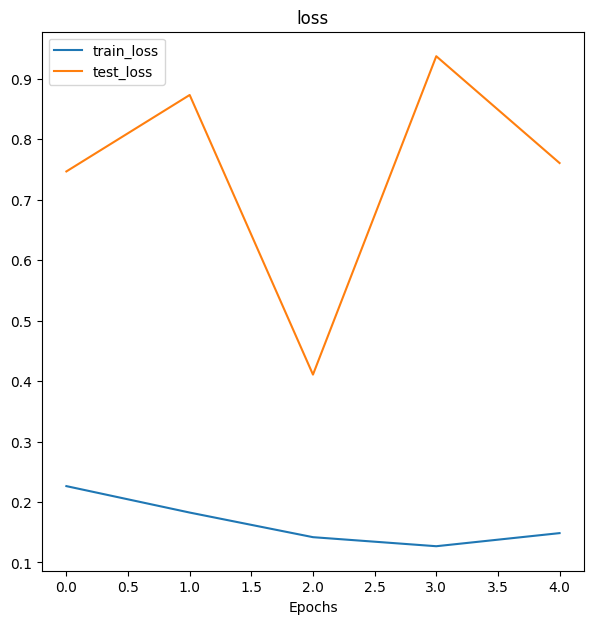

In [59]:
plot_loss_curves(model0_results)